In [1]:
import pandas as pd

# There is a csv file which I put in online. You can also download but we will load directly from the link.
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/EN/S04_Data_Structures_2/DemandScenarios.csv'
demand_scenario_df = pd.read_csv(url, index_col='Week')


In [2]:
demand_scenario_df.head(10)

,Scenario1,Scenario2,Scenario3
Week,,,
1,18,21,17
2,16,16,15
3,13,13,11
4,17,17,16
5,11,11,10
6,20,23,18
7,15,17,13
8,20,20,17
9,15,16,13


In [3]:
# Parameters for the model
init_inv = 27  # initial inventory level
lead_time = 2  # leadtime

# Parameters to set (s,S) policy
s_min =  25 # this is the small s
s_max =  70 # this is the big s

demand_series = demand_scenario_df['Scenario1'] # we are taking the first scenario here
demand_series.head()

Week
1    18
2    16
3    13
4    17
5    11
Name: Scenario1, dtype: int64

In [4]:
# creating an (empty) dataframe to keep the results
column_names = ['Start_Inv', 'Receipt', 'Demand', 'Ending_Inv', 'Order']
n_weeks = len(demand_series.index)
inv_dataframe = pd.DataFrame(index = range(1, n_weeks+1), columns=column_names)
inv_dataframe.index.name ='Week' # give the index name to the output dataframe
inv_dataframe.head()

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN


In [5]:
# initializing current inventory levels and order receipt up to t=lead_time
inv_dataframe.loc[1, 'Start_Inv'] = init_inv
for t in range(1, lead_time+1):
    inv_dataframe.loc[t,'Receipt']=0

# add the values to demand column from the series
inv_dataframe['Demand'] = demand_series
inv_dataframe.head() # review the result

,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,NaN,NaN
2,NaN,0,16,NaN,NaN
3,NaN,NaN,13,NaN,NaN
4,NaN,NaN,17,NaN,NaN
5,NaN,NaN,11,NaN,NaN


In [6]:
# assign values to the entries of the dataframe
for t in range(1, n_weeks+1):
    # computing inventory levels at the begining and end of each period
    if t > 1: # set the Start_Inv equals the inv level at the end of the previous period (Ending_Inv)
        inv_dataframe.loc[t, 'Start_Inv'] = inv_dataframe.loc[t-1, 'Ending_Inv']

    # Calculate inventory flow for Ending_Inv of the current period
    inv_dataframe.loc[t, 'Ending_Inv'] = inv_dataframe.loc[t, 'Start_Inv'] + inv_dataframe.loc[t,'Receipt'] - inv_dataframe.loc[t, 'Demand']

    # Calculating orders and receipts for period t
    intransit_quantity = sum(inv_dataframe.loc[t+1:t+lead_time-1,'Receipt']) # check the intransit (outstanding) order within the leadtime

    if inv_dataframe.loc[t,'Ending_Inv'] + intransit_quantity < s_min: # if 'Ending_Inv' + intransit < s_min in this case an order must be placed
        # create an order Q = s_max - current inventory position
        inv_dataframe.loc[t,'Order'] = s_max - (inv_dataframe.loc[t,'Ending_Inv']+ intransit_quantity)
        # check if we reach the end of dataframe, if not, we add the order receipt after the leadtime
        if t + lead_time <= max(inv_dataframe.index):
            inv_dataframe.loc[t+lead_time,'Receipt'] = inv_dataframe.loc[t,'Order']
    else:
        inv_dataframe.loc[t,'Order'] = 0   # no order is placed if 'Ending_Inv' >= s_min
        if t + lead_time <= max(inv_dataframe.index):
            inv_dataframe.loc[t+lead_time,'Receipt'] = 0  # no orders receipt in t+leadtime periods

In [7]:
print("(s,S) = (",s_min,",",s_max,")")
inv_dataframe

(s,S) = ( 25 , 70 )


,Start_Inv,Receipt,Demand,Ending_Inv,Order
Week,,,,,
1,27,0,18,9,61
2,9,0,16,-7,0
3,-7,61,13,41,0
4,41,0,17,24,46
5,24,0,11,13,0
6,13,46,20,39,0
7,39,0,15,24,46
8,24,0,20,4,0
9,4,46,15,35,0


<Axes: xlabel='Week'>

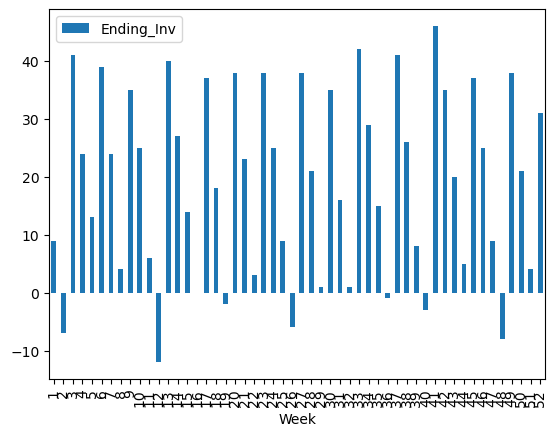

In [8]:
inv_dataframe[["Ending_Inv"]].plot(kind='bar')   # plotting inv levels

<Axes: xlabel='Week'>

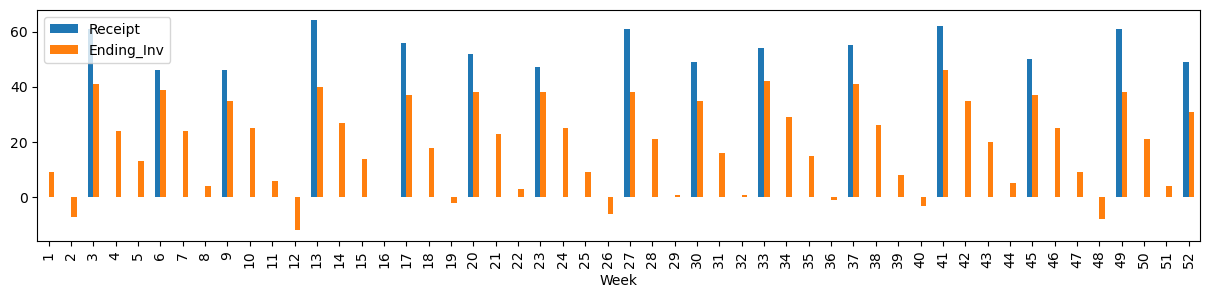

In [9]:
inv_dataframe[["Receipt","Ending_Inv"]].plot(kind='bar', figsize=(15,3))   # plotting inv and receipts and resize the plot

<Axes: >

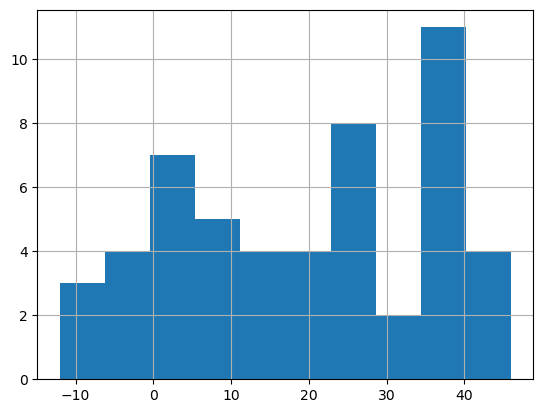

In [10]:
inv_dataframe['Ending_Inv'].hist()

In [11]:
backlog_num = inv_dataframe['Ending_Inv'].lt(0).sum()
backlog_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] < 0].sum() #this number is negative
demand_total = inv_dataframe['Demand'].sum()
order_total = inv_dataframe['Order'].sum()
order_num = inv_dataframe['Order'].gt(0).sum()
inv_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] > 0].sum()

print("Performance of (s,S) = (",s_min,",",s_max,") under demand scenartio:",demand_series.name)
print("Total number of orders =",order_num,", Average order quantity =","{:.2f}".format(order_total/order_num))
print("Average inventory per week =", "{:.2f}".format(inv_total_units/n_weeks))
print("Average number of backlogged units per week =", "{:.2f}".format(backlog_total_units/n_weeks))
print("N. backlog incidents =", inv_dataframe['Ending_Inv'].lt(0).sum())
print("Service Level =", "{:.2f}".format(( 1 - backlog_num/n_weeks)*100),"%") # % of times the demand is completely fulfilled
print("Fill rate =", "{:.2f}".format(((demand_total + backlog_total_units)/demand_total)*100),"%")  # % of quantity fulfilled on-time


Performance of (s,S) = ( 25 , 70 ) under demand scenartio: Scenario1
Total number of orders = 15 , Average order quantity = 54.20
Average inventory per week = 19.92
Average number of backlogged units per week = -0.75
N. backlog incidents = 7
Service Level = 86.54 %
Fill rate = 95.18 %
